# Notebook Setup

In [2]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 4s (254 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (Thi

In [3]:
!pip install pipelineprofiler

     |████████████████████████████████| 880kB 5.5MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/MyDrive/itau/

/content/drive/MyDrive/itau


# Features

In [7]:
import pandas as pd
import numpy as np
from dataset.dataset import Dataset

In [8]:
ds = Dataset()
ds.load_data()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
counts = ds.get_transactions_counts()

In [10]:
def get_features(train=True):
  # Customer features
  customer_feat = pd.get_dummies(ds.customers_df.set_index("id").drop(columns=['Comuna','Profesion']))
  # Transactions features
  input_counts = counts.iloc[:,:-3].copy() if train else counts.copy() #-3 is because these are in the training features
  old_history_feat = pd.DataFrame((input_counts.iloc[:,:-13].sum(axis=1)>0).astype('float'),columns=['old_count']).unstack().fillna(0)
  current_history_feat = input_counts.iloc[:,-13:].unstack().fillna(0)
  # Full features
  features = np.hstack([customer_feat, old_history_feat, current_history_feat])
  return features

In [11]:
# Features
train_features = get_features(train=True)
test_features = get_features(train=False)
# Labels
labels = (counts.iloc[:,-3:].sum(axis=1))
labels = labels.unstack(-1) > 0
actuals = [list(np.array(labels.columns)[x]) for x in labels.values]
labels = labels.astype(int)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Trainning

In [12]:
from autosklearn.classification import AutoSklearnClassifier

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_features, labels)

In [16]:
from autosklearn.metrics import balanced_accuracy

In [41]:
from sklearn.metrics import recall_score

In [45]:
clf = AutoSklearnClassifier(time_left_for_this_task=3600, n_jobs=-1, metric=balanced_accuracy)
clf.fit(X_train, y_train.iloc[:,[1]])
y_pred = clf.predict_proba(X_test)

In [47]:
balanced_accuracy_score(clf.predict(X_test),y_test.iloc[:,1].values)

0.5322887509244775

In [48]:
balanced_accuracy_score(clf2.predict(X_test),y_test.iloc[:,1].values)

0.8308623811679493

In [42]:
recall_score(clf.predict(X_test),y_test.iloc[:,1].values)

0.1263983541211264

In [38]:
balanced_accuracy(clf.predict(X_test),y_test.iloc[:,1])

1.0

In [21]:
_clf.show_models()

"[(0.720000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'adaboost', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'extra_trees_preproc_for_classification', 'classifier:adaboost:algorithm': 'SAMME.R', 'classifier:adaboost:learning_rate': 0.04406168169625495, 'classifier:adaboost:max_depth': 1, 'classifier:adaboost:n_estimators': 166, 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.40534411940800696, 'feature_preprocessor:extra_trees_preproc_for_classification:bootstrap': 'False', 'feature_preprocessor:extra_trees_preproc_for_classification:criterion': 'gi

(array([ 446., 1221., 1628., 2010., 2442., 3038., 3280., 3276., 1700.,
         844.]),
 array([0.33621949, 0.36888499, 0.40155048, 0.43421598, 0.46688147,
        0.49954697, 0.53221246, 0.56487796, 0.59754345, 0.63020895,
        0.66287444]),
 <a list of 10 Patch objects>)

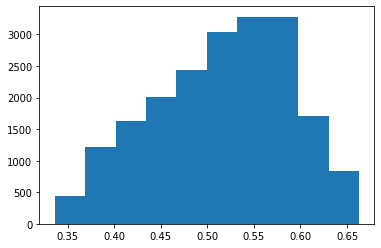

In [20]:
import matplotlib.pyplot as plt
plt.hist(y_pred[:,0])

In [43]:
from lightgbm import LGBMClassifier
clf2 = LGBMClassifier().fit(X_train, y_train.iloc[:,1])

In [80]:
accuracy_score(y_test.iloc[:,1],np.zeros_like(y_test.iloc[:,1]))

0.9109378928840834

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.iloc[:,1], clf2.predict(X_test))

0.910887603721398

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.iloc[:,1], clf.predict(X_test))

0.9109378928840834

In [70]:
clf.show_models()

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


'[(1.000000, MyDummyClassifier(configuration=1, init_params=None, random_state=None)),\n]'

In [49]:
import PipelineProfiler
profiler_data = PipelineProfiler.import_autosklearn(clf)
PipelineProfiler.plot_pipeline_matrix(profiler_data)

Output hidden; open in https://colab.research.google.com to view.